<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*FAN HUANG*]
### ***username***: [*acse-fh223*]
### ***CID***: [*01883792*]


## Data preparation

Import the data we need from Google Drive.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


Import the Python libraries that will be used in our task.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import GaussianBlur
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Install livelossplot for plotting loss functions.
!pip install livelossplot
from livelossplot import PlotLosses

import os


Check if our GPU is available.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

GPU available: Tesla V100-SXM2-16GB


In [4]:
# Design custom functions that access our dataset to get data.
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, img_type, transform=None):
        self.img_dir = img_dir
        self.img_type = img_type
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.img_dir, self.img_names[idx])
                image = Image.open(img_path).convert('L')  # gray
                label = self.assign_label(self.img_type)

                if self.transform:
                    image = self.transform(image)

                return image, label

            except (IOError, OSError):
                #print(f"Error reading file {img_path}. Skipping.")
                idx = (idx + 1) % len(self.img_names)

    @staticmethod
    def assign_label(img_type):
        if img_type == 'real_hand':
            return 0
        elif img_type == 'vae_hand':
            return 1
        elif img_type == 'gan_hand':
            return 2
        else:
            raise ValueError("Invalid image type")


# Define transform
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    # Resize images and use interpolation to fill in the blanks
    transforms.Resize((32, 32), interpolation=InterpolationMode.BICUBIC),
    # Converting images to PyTorch tensors
    transforms.ToTensor()
])


In [5]:
# Read three types of datasets and integrate
real_hand_dataset = CustomImageDataset(img_dir='/content/drive/MyDrive/dlmodule-coursework-2-acse-fh223/real_hands', img_type='real_hand', transform=transform)
vae_hand_dataset = CustomImageDataset(img_dir='/content/drive/MyDrive/dlmodule-coursework-2-acse-fh223/VAE_hands', img_type='vae_hand', transform=transform)
gan_hand_dataset = CustomImageDataset(img_dir='/content/drive/MyDrive/dlmodule-coursework-2-acse-fh223/GAN_hands', img_type='gan_hand', transform=transform)
combined_dataset = ConcatDataset([real_hand_dataset, vae_hand_dataset, gan_hand_dataset])

batch_size = 16

total_size = len(combined_dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# Randomly divide the training and test sets
torch.manual_seed(42)
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Number of batches and number of images
print('number of batches = '+str(len(train_loader)))
print('number of images = '+str(len(train_dataset)))

number of batches = 82
number of images = 1312


## Network design and implementation

CNNs typically achieve excellent performance in image classification tasks.

In [7]:
# Defining the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Maximum pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 output classes
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Through convolutional and pooling layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # spreading image
        x = x.view(-1, 64 * 8 * 8)
        # Through the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Training and evaluation loops

Define the training and evaluation loops, implement livelossplot.

In [8]:
def evaluate_accuracy(model, data_loader):
    model.eval()  # Setting the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
        model.train()  # Setting the model to training mode
        running_loss = 0.0
        logs = {}

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()   # Clearing the gradient
            outputs = model(images) # Forward propagation
            loss = criterion(outputs, labels) # Calculation of losses
            loss.backward()         # Backward propagation
            optimizer.step()        # Updating parameters

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader.dataset)
        val_accuracy = evaluate_accuracy(model, val_loader)
        logs['loss'] = train_loss
        logs['val_accuracy'] = val_accuracy

        liveloss.update(logs)
        liveloss.send()  # Send logs to update charts

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Validation Accuracy: {val_accuracy}%")


## Network training
Use the best hyperparameters and network design here.

*   loss = CrossEntropyLoss
*   Adam lr = 1e-3
*   batch_size = 16



Demonstrate the model's loss in the training set and accuracy in the validation set.

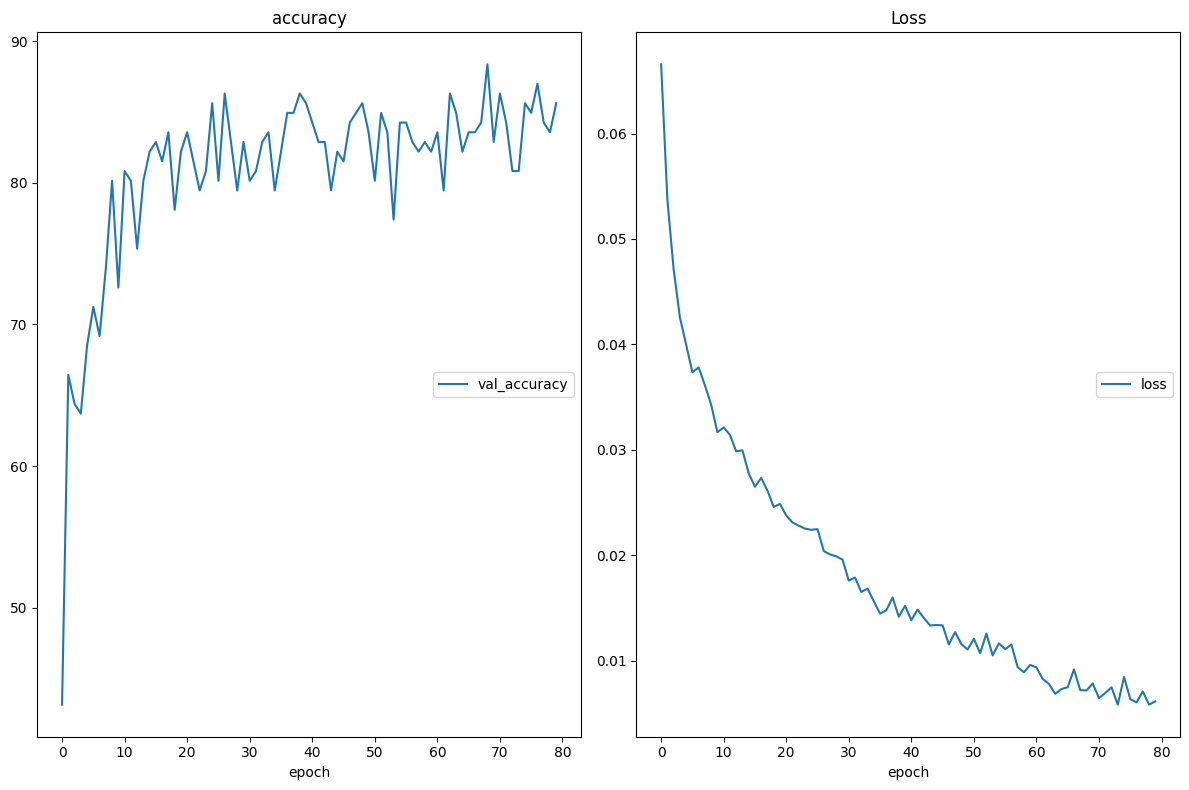

accuracy
	val_accuracy     	 (min:   43.151, max:   88.356, cur:   85.616)
Loss
	loss             	 (min:    0.006, max:    0.067, cur:    0.006)
Epoch 80/80, Loss: 0.006131504200932729, Validation Accuracy: 85.61643835616438%


In [10]:
# Defining the model, loss function and optimizer
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=80)

Showing some of the results predicted by the model.

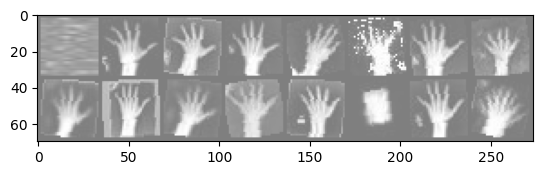

GroundTruth:  2 0 0 0 0 2 0 2 1 0 1 2 0 1 0 2
Predicted:  2 0 2 0 0 2 0 2 1 0 1 1 0 0 0 2


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # Inverse normalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show image
imshow(torchvision.utils.make_grid(images))

# Getting predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Print real labels and predictive labels
print('GroundTruth: ', ' '.join(str(labels[j].item()) for j in range(len(labels))))
print('Predicted: ', ' '.join(str(predicted[j].item()) for j in range(len(predicted))))


## Writing of the csv file

Predict the test set using our model and save the predictions in a csv file.

In [12]:
class UnlabeledDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.img_dir, self.img_names[idx])
                image = Image.open(img_path).convert('L')
                if self.transform:
                    image = self.transform(image)
                return image, self.img_names[idx]
            except (IOError, OSError):
                print(f"Error reading file {self.img_names[idx]}. Skipping.")
                idx = (idx + 1) % len(self.img_names)

# Read unlabeled datasets
unlabeled_dataset = UnlabeledDataset(img_dir='/content/drive/MyDrive/test_hands', transform=transform)

# Create DataLoaders
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

In [13]:
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, image_names in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(zip(image_names, predicted.cpu().numpy()))

    return predictions

predictions = predict(model, unlabeled_loader)


Error reading file test_hand_0256.jpeg. Skipping.
Error reading file test_hand_3551.jpeg. Skipping.
Error reading file test_hand_6259.jpeg. Skipping.


In [14]:
import csv

with open('/content/drive/MyDrive/dlmodule-coursework-2-acse-fh223/acse_fh223_classified_hands.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    for image_name, label in predictions:
        writer.writerow([image_name, label])
